# Gaussian Process Regression for Time Forecast 

Reference [Docs](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py)

## Prepare Notebook
 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

## Example 1

In this first example we consider a seasonal stationary time series.

### Generate Data

- Time Variable
 
Let us define a "time" variable $t\in \mathbb{N}$. 

In [2]:
# Number of samples. 
n = 700
# Generate "time" variable. 
t = np.arange(n)

data_df = pd.DataFrame({'t' : t})

- Seasonal Component

Let us define a function to generate seasonal components (Fourier modes).  

In [3]:
# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    y1 = amplitude * np.sin((2*np.pi)*t/period) 
    
    return(y1)

# Add two seasonal components. 
data_df ['s1'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=2, period=40))

# Define target variable. 
data_df ['y1'] = data_df ['s1']

Let us plot this seasonal variable:

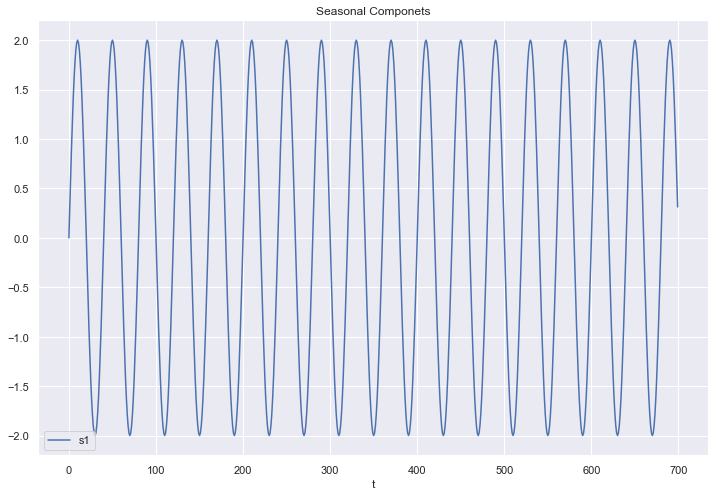

In [4]:
plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots()
sns.lineplot(x='t', y='s1', data=data_df, label='s1', ax=ax) 
ax.set(title='Seasonal Componets', xlabel='t', ylabel='')
ax.legend(loc='lower left');

- Gaussian Noise 

Finally, we add some noise.

In [5]:
# Set noise standard deviation. 
sigma_n = 0.3

data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
# Add noise to target variable. 
data_df ['y1'] = data_df ['y1'] + data_df ['epsilon']

Let us plot the resulting data:

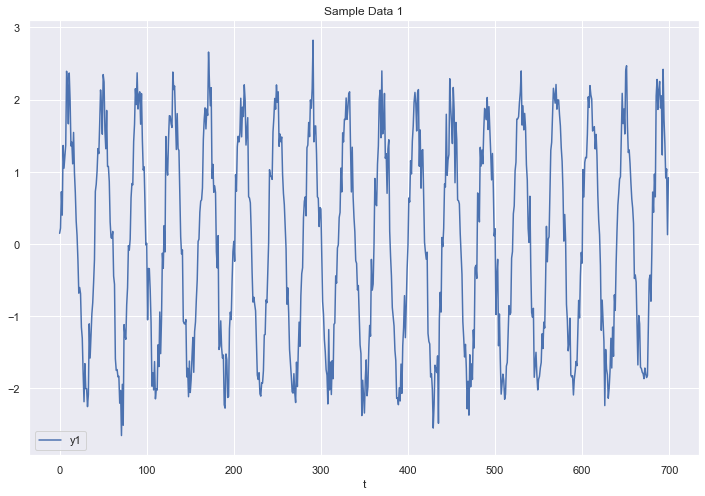

In [6]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y1', data=data_df, label='y1', ax=ax) 
ax.set(title='Sample Data 1', xlabel='t', ylabel='')
ax.legend(loc='lower left');

### Define Model

Let us now define the kernel of the gaussian process model. We include:

- [`WhiteKernel`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.WhiteKernel.html) to account for noise. 

- [`ExpSineSquared`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html) to model the periodic component.

We add bounds to the kernel hyper-parameters which are optimized by maximizing the log-marginal-likelihood (see [documentation](https://scikit-learn.org/stable/modules/gaussian_process.html)).

In [7]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

kernel_1  = k0 + k1 

Next we initialize the [`GaussianProcessRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor) object.

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp1 = GaussianProcessRegressor(
    kernel=kernel_1, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

### Split Data 

We now prepare and split the data for the model.

In [9]:
X = data_df['t'].values.reshape(n ,1)
y = data_df['y1'].values.reshape(n ,1)

prop_train = 0.7
n_train = round(prop_train*n)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

### Model Fit + Predictions

Let us fit the model and generate predictions.

In [10]:
gp1.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [11]:
#Generate predictions.
y_pred, y_std = gp1.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + data_df['y_std']

We plot the predictions.

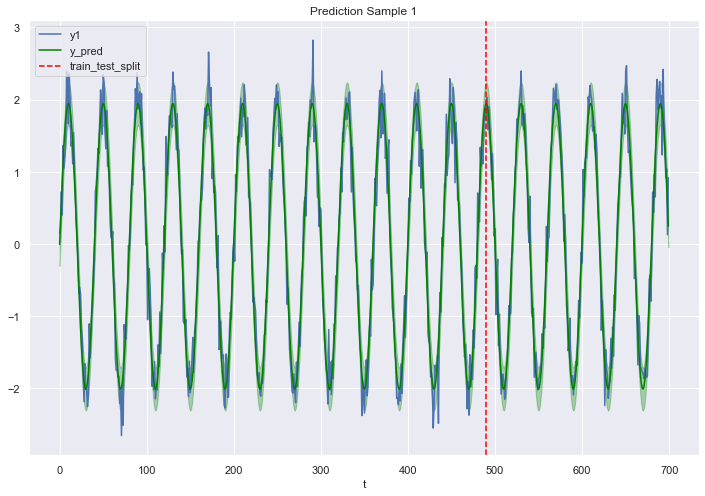

In [12]:
fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color='green', 
    alpha=0.3
)

sns.lineplot(x='t', y='y1', data=data_df, label = 'y1', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, label='y_pred', color='green', ax=ax)

ax.axvline(n_train, color='red', linestyle='--', label='train_test_split')
ax.set(title='Prediction Sample 1', xlabel='t', ylabel='')
ax.legend(loc='upper left');

Let us compute the $R^2$ of the prediction on the test set. 

In [13]:
gp1.score(X=X_test, y=y_test)

0.9617805915804019

## Example 2

In this example we add a linear trend component.

- Linear Trend Component

In [14]:
# Generate trend component. 
def linear_trend(beta, t):
    
    trend_comp = beta * t 
    
    return(trend_comp)

data_df ['tr1'] = data_df['t'].apply(lambda x : linear_trend(0.01, x))

# Add trend to target variable y_1. 
data_df ['y2'] = data_df ['y1'] + data_df ['tr1']

Let us see the trend plot:

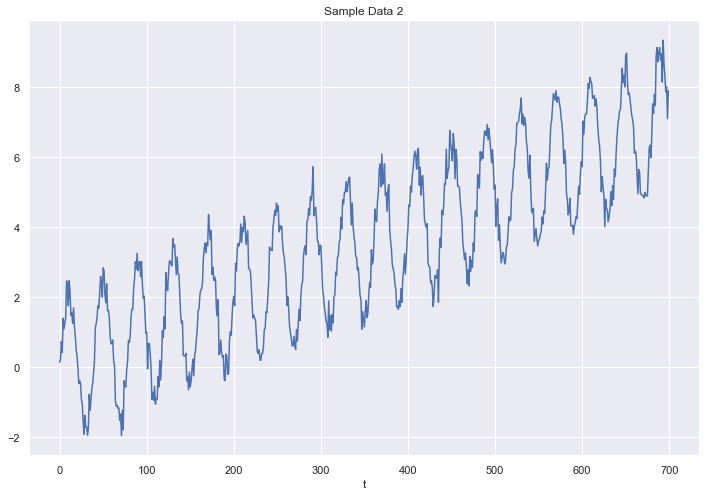

In [15]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y2', data=data_df, ax=ax)
ax.set(title='Sample Data 2', xlabel='t', ylabel='');

### Define Model

For this second example we add a [`RBF`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html) kernel to model the trend component. 

In [16]:
from sklearn.gaussian_process.kernels import RBF

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

k2 = ConstantKernel(constant_value=10, constant_value_bounds=(1e-2, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4)) 

kernel_2  = k0 + k1 + k2

In [17]:
# Define GaussianProcessRegressor object. 
gp2 = GaussianProcessRegressor(
    kernel=kernel_2, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

### Split Data 

We split the data as above.

In [18]:
y = data_df['y2'].values.reshape(n ,1)
y_train = y[:n_train]
y_test = y[n_train:]

### Model Fit + Predictions

In [19]:
gp2.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40) + 3.16**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [20]:
# Generate predictions.
y_pred, y_std = gp2.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + data_df['y_std']

We plot the predictions.

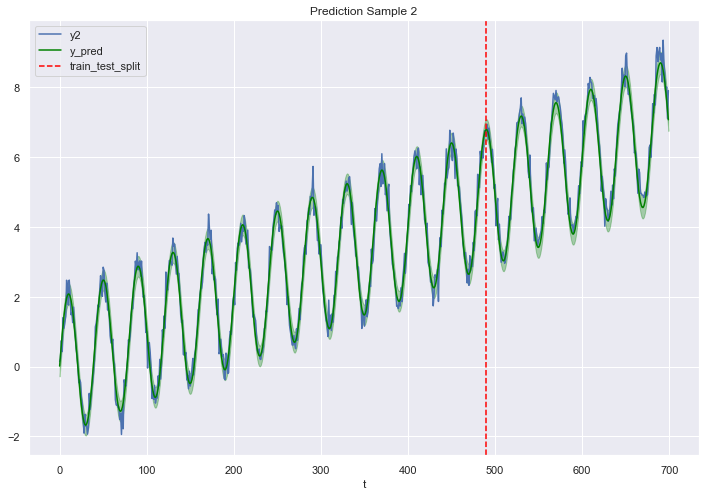

In [21]:
fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color='green', 
    alpha=0.3
)

sns.lineplot(x='t', y='y2', data=data_df, label = 'y2', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, label='y_pred', color='green', ax=ax)

ax.axvline(n_train, color='red', linestyle='--', label='train_test_split')
ax.set(title='Prediction Sample 2', xlabel='t', ylabel='')
ax.legend(loc='upper left');

Let us compute the $R^2$ of the prediction on the test set for this second model. 

In [22]:
gp2.score(X=X_test, y=y_test)

0.961481049537297

## Example 3

In this third example we add a second sesonal component.

- Add Other Seasonal Component

In [23]:
# Create other seasonal component.
data_df ['s2'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=1, period=13.3))
# Add to y_2.
data_df ['y3'] = data_df ['y2'] + data_df ['s2'] 

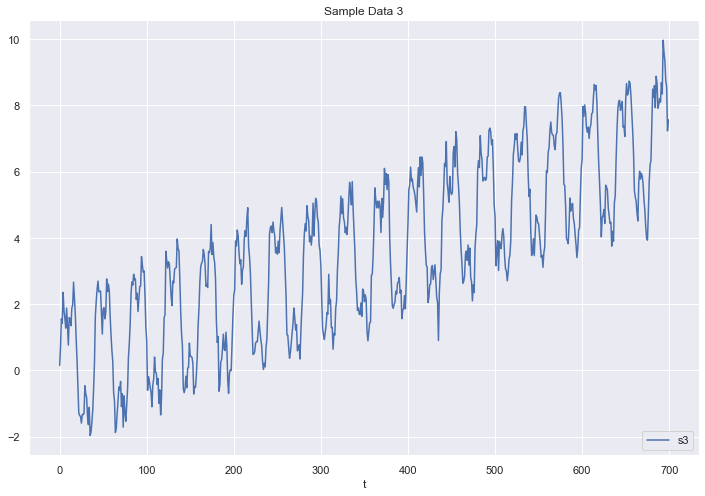

In [24]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y3', data=data_df, label='s3', ax=ax) 
ax.set(title='Sample Data 3', xlabel='t', ylabel='')
ax.legend(loc='lower right');

### Define Model

To the second model kernel we add another `ExpSineSquared`.

In [25]:
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

k2 = ConstantKernel(constant_value=10, constant_value_bounds=(1e-2, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4)) 

k3 = ConstantKernel(constant_value=1) * ExpSineSquared(length_scale=1.0, periodicity=12, periodicity_bounds=(10, 15))

kernel_3  = k0 + k1 + k2 + k3

In [26]:
# Define GaussianProcessRegressor object. 
gp3 = GaussianProcessRegressor(
    kernel=kernel_3, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

### Split Data 

In [27]:
y = data_df['y3'].values.reshape(n ,1)
y_train = y[:n_train]
y_test = y[n_train:]

### Model Fit + Predictions

In [28]:
gp3.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40) + 3.16**2 * RBF(length_scale=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=12),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [29]:
y_pred, y_std = gp3.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + data_df['y_std']

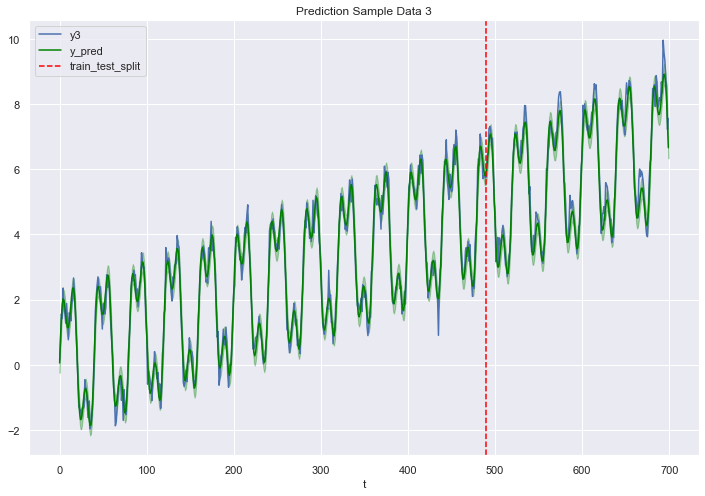

In [30]:
fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color='green', 
    alpha=0.3
)

sns.lineplot(x='t', y='y3', data=data_df, label = 'y3', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, label='y_pred', color='green', ax=ax)

ax.axvline(n_train, color='red', linestyle='--', label='train_test_split')
ax.set(title='Prediction Sample Data 3', xlabel='t', ylabel='')
ax.legend(loc='upper left');

### Example 4

In this last example we consider a non-linear trend component.

- Non-Lnear Trend Component

In [31]:
# Generate trend component. 
def non_linear_trend(t):
    
    trend_comp = 0.5 * np.power(t, 1/2)
    
    return(trend_comp)

data_df ['tr2'] = data_df['t'].apply(non_linear_trend)

Let us see the trend plot:

In [32]:
# Add trend to target variable. 
data_df ['y4'] = data_df ['y3'] + data_df ['tr2']

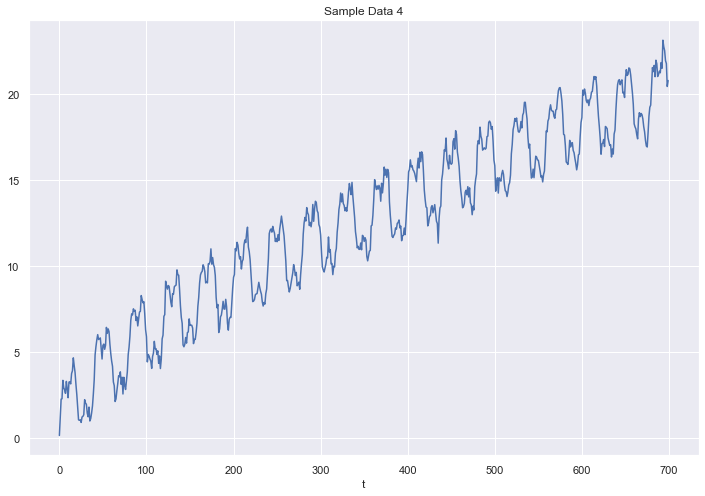

In [33]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y4', data=data_df, ax=ax)
ax.set(title='Sample Data 4', xlabel='t', ylabel='');

### Define Model

In [34]:
from sklearn.gaussian_process.kernels import RationalQuadratic

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

k2 = ConstantKernel(constant_value=10, constant_value_bounds=(1e-2, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4)) 

k3 = ConstantKernel(constant_value=1) * ExpSineSquared(length_scale=1.0, periodicity=12, periodicity_bounds=(10, 15))

kernel_4  = k0 + k1 + k2 + k3 

In [35]:
# Define GaussianProcessRegressor object. 
gp4 = GaussianProcessRegressor(
    kernel=kernel_4, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

### Split Data 

In [36]:
y = data_df['y4'].values.reshape(n ,1)
y_train = y[:n_train]
y_test = y[n_train:]

### Model Fit + Predictions

In [37]:
gp4.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40) + 3.16**2 * RBF(length_scale=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=12),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [38]:
y_pred, y_std = gp4.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + data_df['y_std']

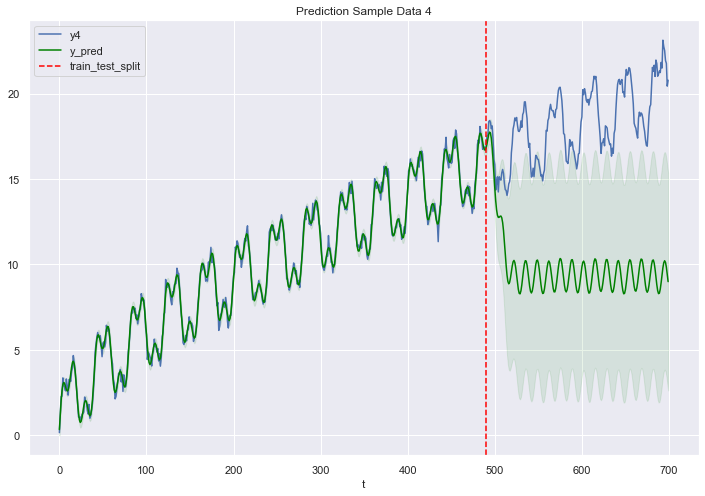

In [39]:
fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color='green', 
    alpha=0.3**2
)

sns.lineplot(x='t', y='y4', data=data_df, label = 'y4', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, label='y_pred', color='green', ax=ax)

ax.axvline(n_train, color='red', linestyle='--', label='train_test_split')
ax.set(title='Prediction Sample Data 4', xlabel='t', ylabel='')
ax.legend(loc='upper left');